1. Drop out;
2. Data augmentation;
3. Weight sharing.

In [1]:
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
import dlc_practical_prologue as helper

---
### Siamese network with auxiliary loss

We do not use drop out in siamese network because we cannot promise for one pair of images, for each image the same nodes are dropped out.

In [17]:
import torchvision.transforms as transforms
class rotated_dataset(Data.Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [250]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    for b in range(0, input.size(0), mini_batch_size):
        output,_,_,_,_ = model(input.narrow(0, b, mini_batch_size))
        target_patch = target.narrow(0, b, mini_batch_size)#.float()
        _,output = output.max(1)
        nb_errors += (output != target_patch).sum().data.item()
    return nb_errors/target.shape[0]

In [206]:
class CNN_Siamese(nn.Module):
    def __init__(self):
        super(CNN_Siamese, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (2, 14, 14)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=32,            # n_filters
                kernel_size=2,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(32, 64, 2, 1, 1),     # output shape (32, 14, 14)
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(64, 128, 2, 1, 1),     # output shape (32, 14, 14)
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc1 = nn.Linear(128 *2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)
        self.out = nn.Linear(20,2)

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        output = self.fc2(x)
        return output,x
    
    def forward(self,x):
        input1 = x.narrow(1,0,1)
        input2 = x.narrow(1,1,1)
        output1,last_layer1 = self.forward_once(input1)
        output2,last_layer2 = self.forward_once(input2)
        output = torch.cat([output1,output2],dim=1)
        output = self.out(output).squeeze()
        return output,output1,output2,last_layer1,last_layer2
        
cnn_siamese = CNN_Siamese()
print(cnn_siamese)  # net architecture

CNN_Siamese(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)


In [207]:
pytorch_total_params = sum(p.numel() for p in cnn_siamese.parameters() if p.requires_grad)
print(pytorch_total_params)

74836


In [208]:
# from torchsample.transforms import RandomTranslate
# translate = RandomTranslate(translation_range=(0.3, 0.3))
# translated_train = torch.zeros(1000, 2, 14, 14)
# translated_test = torch.zeros(1000, 2, 14, 14)
# for i in range(1000):
#     translated_train[i,:,:,:] = translate(train_input[i,:,:,:])
#     translated_test[i,:,:,:] = translate(test_input[i,:,:,:])

In [209]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

augumented_data = rotated_dataset(train_input, transform)
shuffle_index = torch.randperm(1000)
train_input = torch.cat((train_input,augumented_data.data),0)
train_classes = torch.cat((train_classes, train_classes), 0)
train_target = torch.cat((train_target, train_target), 0)

train_input, train_classes, train_target = train_input[shuffle_index], train_classes[shuffle_index], train_target[shuffle_index]

augumented_data = rotated_dataset(test_input, transform)
shuffle_index = torch.randperm(1000)
test_input = torch.cat((test_input,augumented_data.data),0)
test_classes = torch.cat((test_classes, test_classes), 0)
test_target = torch.cat((test_target, test_target), 0)
test_input, test_classes, test_target = test_input[shuffle_index], test_classes[shuffle_index], test_target[shuffle_index]


In [217]:
criterion(output,y_tr_target)

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [220]:
y_tr_class.narrow(1,0,1).squeeze().shape

torch.Size([100])

In [226]:
y_tr_class.narrow(1,0,1).squeeze().int()

tensor([4, 1, 4, 9, 4, 7, 0, 4, 7, 9, 5, 9, 8, 6, 8, 7, 2, 2, 0, 5, 3, 2, 2, 3,
        6, 6, 4, 4, 6, 0, 4, 6, 6, 8, 5, 1, 8, 6, 6, 5, 5, 2, 6, 7, 1, 0, 1, 3,
        0, 3, 5, 7, 2, 8, 1, 7, 1, 4, 0, 9, 5, 1, 5, 9, 0, 1, 1, 0, 8, 8, 3, 4,
        3, 6, 2, 7, 1, 6, 6, 0, 4, 6, 1, 0, 3, 5, 4, 2, 1, 8, 9, 2, 3, 4, 6, 4,
        9, 9, 7, 7], dtype=torch.int32)

In [227]:
train_target.narrow(0, b, mini_batch_size)

tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1])

In [253]:
model = CNN_Siamese()

mini_batch_size=100
EPOCH = 25
LR = 0.005              # learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# criterion2 = nn.BCEWithLogitsLoss()

for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        
        x_tr = train_input.narrow(0, b, mini_batch_size)
        y_tr_class = train_classes.narrow(0, b, mini_batch_size)
        y_tr_target = train_target.narrow(0, b, mini_batch_size)#.float()
        x_tr = Variable(x_tr)   # batch x
        y_tr_class = Variable(y_tr_class)   # batch y
        
        output,output1,output2,last_layer1,last_layer2 = model(x_tr)               # cnn output
#         loss = criterion(output1, y_tr_class.narrow(1,0,1).squeeze())+criterion(output2, y_tr_class.narrow(1,1,1).squeeze())+criterion2(output,y_tr_target)   # cross entropy loss
        loss = criterion(output1, y_tr_class.narrow(1,0,1).squeeze())+criterion(output2, y_tr_class.narrow(1,1,1).squeeze())+criterion(output,y_tr_target)   # cross entropy loss
    
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    
    train_error = compute_nb_errors(model, train_input, train_target, mini_batch_size)
    test_error = compute_nb_errors(model, test_input, test_target, mini_batch_size)
    
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train error: %.2f' % train_error)
    print('Epoch: ', epoch, '| test error: %.2f' % test_error,'\n\n')


Epoch:  0 | train loss: 5.5094 | train error: 0.41
Epoch:  0 | test error: 0.43 


Epoch:  1 | train loss: 4.8966 | train error: 0.39
Epoch:  1 | test error: 0.42 


Epoch:  2 | train loss: 3.5834 | train error: 0.40
Epoch:  2 | test error: 0.43 


Epoch:  3 | train loss: 2.4093 | train error: 0.35
Epoch:  3 | test error: 0.38 


Epoch:  4 | train loss: 1.6804 | train error: 0.29
Epoch:  4 | test error: 0.34 


Epoch:  5 | train loss: 1.2847 | train error: 0.27
Epoch:  5 | test error: 0.31 


Epoch:  6 | train loss: 1.0018 | train error: 0.24
Epoch:  6 | test error: 0.27 


Epoch:  7 | train loss: 0.9962 | train error: 0.22
Epoch:  7 | test error: 0.24 


Epoch:  8 | train loss: 0.8047 | train error: 0.21
Epoch:  8 | test error: 0.24 


Epoch:  9 | train loss: 0.7350 | train error: 0.18
Epoch:  9 | test error: 0.22 


Epoch:  10 | train loss: 0.7115 | train error: 0.17
Epoch:  10 | test error: 0.20 


Epoch:  11 | train loss: 0.6461 | train error: 0.17
Epoch:  11 | test error: 0.20 




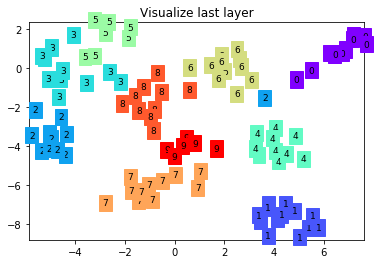

In [254]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer1.data.numpy()[:plot_only, :])
labels = y_tr_class.narrow(1,0,1).squeeze().numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)
plt.ioff()
